In [ ]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [ ]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler


Import necessary libraries


In [ ]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [ ]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [ ]:
version='forPdata423_numPaths'


In [ ]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [ ]:
rssidsnums=[int(x[4:]) for x in data.columns if 'rsid' in x]
print(len(rssidsnums))

312


In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,rsid11,rsid12,rsid13,rsid14,rsid15,rsid16,rsid17,rsid18,rsid19,rsid20,rsid21,rsid22,rsid23,rsid24,rsid25,rsid26,rsid27,rsid28,rsid29,rsid30,rsid31,rsid32,rsid33,rsid34,rsid35,rsid36,rsid37,rsid38,rsid39,rsid40,...,rsid277,rsid278,rsid279,rsid280,rsid281,rsid282,rsid283,rsid284,rsid285,rsid286,rsid287,rsid288,rsid289,rsid290,rsid291,rsid292,rsid293,rsid294,rsid295,rsid296,rsid297,rsid298,rsid299,rsid300,rsid301,rsid302,rsid303,rsid304,rsid305,rsid306,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,-999,-85,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-48,-48,-49,-44,-43,-43,-999,-999,-999,-999,-999,-999,...,-81,-80,-999,-999,-999,-87,-999,-999,-78,-79,-78,-79,-79,-78,-999,-999,-999,-999,-999,-999,-999,-81,-82,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-84,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-56,-999,-999,-39,-43,-42,-999,-999,-999,-999,-999,-999,...,-82,-82,-84,-85,-81,-87,-999,-999,-999,-999,-85,-999,-88,-999,-999,-999,-999,-999,-999,-999,-999,-85,-86,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-50,-51,-51,-43,-49,-47,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-87,-87,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [ ]:
# print('split path-timestamp in 2 columns')
# data[['path','timestamp']]=data['path-timestamp'].str.split('-',expand=True)
# print('remove path-timestamp column')
# data.drop('path-timestamp', axis=1,inplace=True)

In [ ]:
NUM_FEATS=60
########################################## Create data ##########################################
num_of_lines=len(data)
data2=[]
for i in range(num_of_lines):
    # if i % 1000 == 0:
    #     print(f'current:{i}')

    tmp=data.iloc[i,:-4].astype(int).reset_index(drop=False)
    tmp.columns=['BSSID','Signal_Strength']
    tmp=tmp.sort_values(['Signal_Strength', 'BSSID'],ascending=False)
    target = data.iloc[i,-4:]

    line = pd.concat([pd.Series(tmp.BSSID.astype(str)), tmp.Signal_Strength.astype(int), target])

    line.index = [str(i) for i in range(2*len(tmp)+4)]

    data2.append(line.values)
data2 = pd.DataFrame(np.stack(data2))

data2.columns = [f'BSSID{str(i)}' for i in range(len(tmp))] + [f'Signal_Strength_{str(i)}' for i in range(len(tmp))] + ['x','y', 'timestamp', 'path']
# data.to_csv(SAVEDIR+file_name, index=False)

data=data2.copy()

BSSID_FEATS=[x for x in data.columns if x.startswith('BSSID')]
RSSI_FEATS=[x for x in data.columns if x.startswith('Signal_Strength')]

# len(BSSID_FEATS),len(RSSI_FEATS)


wifi_bssids = []
for i in range(len(BSSID_FEATS)):
    wifi_bssids.extend(data.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

wifi_bssids = np.unique(wifi_bssids)
wifi_bssids_size = len(wifi_bssids)
# print(wifi_bssids_size)

wifi_bssids_dict={}
counter = 0               #<-------------  1 not 0
for wf in wifi_bssids:
    wifi_bssids_dict[wf]=counter
    counter+=1


for i in BSSID_FEATS:
    data.loc[:,i] = data.loc[:,i] .apply(lambda x: wifi_bssids_dict[x])

data.loc[:,BSSID_FEATS[:NUM_FEATS]]=data.loc[:,BSSID_FEATS[:NUM_FEATS]].astype('float32')

Ms=np.mean(data.loc[:,RSSI_FEATS[:NUM_FEATS]].values.astype('float32'),axis=0)
Ss=np.std(data.loc[:,RSSI_FEATS[:NUM_FEATS]].values.astype('float32'),axis=0)

for i in range(NUM_FEATS):
    data.loc[:,RSSI_FEATS[i]] = ((data.loc[:,RSSI_FEATS[i]] - Ms[i])/(Ss[i]+1)).astype('float32')

unpaths=data.path.unique()

data.x=data.x.values.astype('float32')
data.y=data.y.values.astype('float32')
##########################################

In [ ]:
dataA=data.copy()

In [ ]:
# num_of_lines=len(dataA)
# data2=[]
# for i in range(num_of_lines):
#     # if i % 1000 == 0:
#     #     print(f'current:{i}')

#     tmp=dataA.iloc[i,:-4].astype(int).reset_index(drop=False)
#     tmp.columns=['BSSID','Signal_Strength']
#     tmp=tmp.sort_values(['Signal_Strength', 'BSSID'],ascending=False)
#     target = dataA.iloc[i,-4:]

#     line = pd.concat([pd.Series(tmp.BSSID.astype(str)), tmp.Signal_Strength.astype(int), target])

#     line.index = [str(i) for i in range(2*len(tmp)+4)]

#     data2.append(line.values)
# data2 = pd.DataFrame(np.stack(data2))

# data2.columns = [f'BSSID{str(i)}' for i in range(len(tmp))] + [f'Signal_Strength_{str(i)}' for i in range(len(tmp))] + ['x','y', 'timestamp', 'path']
# # data.to_csv(SAVEDIR+file_name, index=False)


In [ ]:
# target

In [ ]:
# data=data2.copy()

In [ ]:
# data.head()

In [ ]:
# a=data.loc[:,[x for x in data.columns if x.startswith('Signal_Strength')]].max().values
# MAX_NUM_WIFIS=np.where(a[a>-999])[0].max()
# MAX_NUM_WIFIS

In [ ]:

# wifi_bssids = []
# for i in range(len(BSSID_FEATS)):
#     wifi_bssids.extend(data.iloc[:,i].values.tolist())
# wifi_bssids = list(set(wifi_bssids))

# wifi_bssids = np.unique(wifi_bssids)
# wifi_bssids_size = len(wifi_bssids)
# print(wifi_bssids_size)

# wifi_bssids_dict={}
# counter = 0               #<-------------  1 not 0
# for wf in wifi_bssids:
#     wifi_bssids_dict[wf]=counter
#     counter+=1
# # import joblib
# # joblib.dump(wifi_bssids_dict,'wifi_bssids_dict2')    

In [ ]:
# for i in BSSID_FEATS[:MAX_NUM_WIFIS]:
# for i in BSSID_FEATS:
#     data.loc[:,i] = data.loc[:,i] .apply(lambda x: wifi_bssids_dict[x])

In [ ]:
# data.loc[:,BSSID_FEATS[:MAX_NUM_WIFIS]]=data.loc[:,BSSID_FEATS[:MAX_NUM_WIFIS]].astype('float32')

In [ ]:
# Ms=np.mean(data.loc[:,RSSI_FEATS[:MAX_NUM_WIFIS]].values.astype('float32'),axis=0)
# Ss=np.std(data.loc[:,RSSI_FEATS[:MAX_NUM_WIFIS]].values.astype('float32'),axis=0)
# # joblib.dump(Ms,'means_of_rssids2')
# # joblib.dump(Ss,'stds_of_rssids2')
# Ms[:5],Ss[:5]

In [ ]:
# for i in range(MAX_NUM_WIFIS):
#     data.loc[:,RSSI_FEATS[i]] = ((data.loc[:,RSSI_FEATS[i]] - Ms[i])/(Ss[i]+1)).astype('float32')

In [ ]:
# data.loc[:,RSSI_FEATS].head()

In [ ]:
# TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
# len(TRAIN_FEATS)

In [ ]:
# d2=data.loc[:,TRAIN_FEATS].copy()
# d2[d2==-999]=0
# d2[d2!=0]=1

In [ ]:
# d2.head()

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(np.sum(d2,0),50)
# plt.show()

In [ ]:

# Ms=np.mean(data.loc[:,TRAIN_FEATS].values,axis=0)
# Ss=np.std(data.loc[:,TRAIN_FEATS].values,axis=0)

# # joblib.dump(Ms,'means_of_rssids2')
# # joblib.dump(Ss,'stds_of_rssids2')

# for i in range(len(TRAIN_FEATS)):
#     data.loc[:,TRAIN_FEATS[i]] = (data.loc[:,TRAIN_FEATS[i]] - Ms[i])/(Ss[i]+1)

In [ ]:
# unpaths=data.path.unique()

In [ ]:
# print('we have ',len(unpaths),' unique paths')

In [ ]:
# USE_FEATS=TRAIN_FEATS[:]
# # USE_FEATS=np.array(TRAIN_FEATS)[np.where((np.sum(d2,0))>200)[0]]
# USE_FEATS.shape

### CV TRAIN

In [ ]:

def create_model(bssid_size1, rssi_size):

    def myFunc(x,size=bssid_size1):
        return x[:,:size]
    def myFunc2(x,size=bssid_size1):
        return x[:,size:]
            
    input_layer_all = L.Input(shape=(bssid_size1+ rssi_size,), name='inputL', dtype='float32')
    # input_layer_all = L.Dropout(0.1, name='do1')(input_layer_all)    
    input_embd_layer = L.Lambda(myFunc )(input_layer_all)
    x1 = L.Embedding(wifi_bssids_size, 4, name='emb_bssid')(input_embd_layer)
#     x1 = L.Dropout(0.1)(x1)
    x1 = L.Flatten( name='fl_bssid')(x1)
    # print(x1.shape)
    
    
    # rssi feats
    # input_layer = L.Input((rssi_size, ), name='input_rsid', dtype='float32')
    input_layer = L.Lambda(myFunc2)(input_layer_all)
    x2 = L.BatchNormalization(name='bn1')(input_layer)
    x2 = L.Dense(rssi_size * 1, name='dn1')(x2)
    x2 = L.Dropout(0.1, name='do1')(x2)    
#     x2 = L.Dense(NUM_FEATS * 4, activation='relu')(x2)
    # print(x2.shape)
    

    
    # main stream
    x = L.Concatenate(axis=1, name='concat')([x1, x2])
    # print(x.shape)
#     x = L.Flatten()(x)
    x = L.BatchNormalization(name='bn2')(x)
    x = L.Dropout(0.5, name='do2')(x)
    x = L.Dense(256, name='dn2')(x)
#     x = L.Dropout(0.1)(x)
#     x = L.Dense(256, activation='relu')(x)

    x = L.Reshape((1 , 256), name='resh')(x)
#     x = L.Reshape((1 , -1))(x)
    # print(x.shape)
    x = L.BatchNormalization(name='bn3')(x)
    x = L.LSTM(128, return_sequences=True, name='lstm1')(x)
    x = L.Dropout(0.2, name='do3')(x)
    x = L.BatchNormalization(name='bn4')(x)    
    x = L.LSTM(64, return_sequences=True, name='lstm2')(x)
    x = L.Dropout(0.2, name='do4')(x)
#     x = L.Bidirectional(L.LSTM(512, return_sequences=True))(x)
#     x = L.BatchNormalization()(x)    
#     x = L.Bidirectional(L.LSTM(256, return_sequences=True))(x)    
    x = L.BatchNormalization(name='bn5')(x)
    x = L.LSTM(32, return_sequences=False, name='lstm3')(x)
    # x = L.LSTM(128, return_sequences=False, name='lstm3')(x)
#     x = L.Dropout(0.1)(x)
    # print(x.shape)
    
    
    
    x = L.BatchNormalization(name='bn6')(x)
#     x = L.Dropout(0.1)(x)
#     x = L.Dense(64)(x)
# #     x = L.Dropout(0.1)(x)
#     x = L.Dense(128)(x)
# #     x = L.Dense(64, activation='relu')(x)

    
    
    output_layer_1 = L.Dense(2, name='xy')(x)
#     output_layer_2 = L.Dense(1, activation='softmax', name='floor')(x)

    model = M.Model(inputs=input_layer_all, 
#     model = M.Model([input_embd_layer, input_embd_layerb, input_layer, input_site_layer], 
                    outputs=output_layer_1)
#                     [output_layer_1, output_layer_2])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss='mse', metrics=['mse'])

    return model    
# model =  create_model(bssid_size1=MAX_NUM_WIFIS, rssi_size=MAX_NUM_WIFIS )
# model.summary()

In [ ]:
def _cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // snapshots))
    cos_inner /= epochs // snapshots
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)

In [ ]:
# NUM_FEATS=MAX_NUM_WIFIS
# NUM_FEATS

In [ ]:
# # data.loc[:, ['x', 'y'] ]=data.loc[:, ['x', 'y'] ].values.astype('float32')
# # data.loc[:, ['x'] ]=data.loc[:, ['x'] ].values.astype('float32')
# # data.loc[:, ['y'] ]=data.loc[:, ['y'] ].values.astype('float32')
# data.x=data.x.values.astype('float32')
# data.y=data.y.values.astype('float32')
# data.loc[:, ['x', 'y'] ].dtypes

In [ ]:
# X_train.min().values

In [ ]:
# X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].astype('float32').values
# X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values
# X_train.loc[:,RSSI_FEATS[NUM_FEATS-1]].values
# np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1).shape
# np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1).max()
# data.loc[:, ['x', 'y'] ].reset_index(drop=True).values

In [ ]:
dataA.head()

,BSSID0,BSSID1,BSSID2,BSSID3,BSSID4,BSSID5,BSSID6,BSSID7,BSSID8,BSSID9,BSSID10,BSSID11,BSSID12,BSSID13,BSSID14,BSSID15,BSSID16,BSSID17,BSSID18,BSSID19,BSSID20,BSSID21,BSSID22,BSSID23,BSSID24,BSSID25,BSSID26,BSSID27,BSSID28,BSSID29,BSSID30,BSSID31,BSSID32,BSSID33,BSSID34,BSSID35,BSSID36,BSSID37,BSSID38,BSSID39,...,Signal_Strength_276,Signal_Strength_277,Signal_Strength_278,Signal_Strength_279,Signal_Strength_280,Signal_Strength_281,Signal_Strength_282,Signal_Strength_283,Signal_Strength_284,Signal_Strength_285,Signal_Strength_286,Signal_Strength_287,Signal_Strength_288,Signal_Strength_289,Signal_Strength_290,Signal_Strength_291,Signal_Strength_292,Signal_Strength_293,Signal_Strength_294,Signal_Strength_295,Signal_Strength_296,Signal_Strength_297,Signal_Strength_298,Signal_Strength_299,Signal_Strength_300,Signal_Strength_301,Signal_Strength_302,Signal_Strength_303,Signal_Strength_304,Signal_Strength_305,Signal_Strength_306,Signal_Strength_307,Signal_Strength_308,Signal_Strength_309,Signal_Strength_310,Signal_Strength_311,x,y,timestamp,path
0,240.0,239.0,238.0,223.0,211.0,234.0,51.0,50.0,52.0,304.0,302.0,143.0,307.0,306.0,305.0,146.0,144.0,212.0,208.0,206.0,140.0,210.0,209.0,207.0,142.0,141.0,198.0,196.0,297.0,296.0,295.0,222.0,220.0,197.0,85.0,84.0,83.0,221.0,271.0,272.0,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.259998,25.889999,1633934464983,record_2021_10_11_07_41_02
1,240.0,239.0,238.0,223.0,211.0,234.0,51.0,50.0,52.0,304.0,302.0,143.0,307.0,306.0,305.0,146.0,144.0,212.0,208.0,206.0,140.0,210.0,209.0,207.0,142.0,141.0,198.0,196.0,297.0,296.0,295.0,222.0,220.0,197.0,85.0,84.0,83.0,221.0,271.0,272.0,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.259998,25.889999,1633934467125,record_2021_10_11_07_41_02
2,238.0,240.0,239.0,211.0,303.0,302.0,51.0,52.0,50.0,307.0,306.0,305.0,84.0,202.0,198.0,197.0,196.0,85.0,83.0,199.0,140.0,23.0,220.0,208.0,201.0,146.0,77.0,221.0,117.0,76.0,203.0,119.0,210.0,297.0,296.0,143.0,144.0,274.0,311.0,310.0,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.259998,25.889999,1633934469251,record_2021_10_11_07_41_02
3,238.0,240.0,239.0,211.0,303.0,302.0,51.0,52.0,50.0,307.0,306.0,305.0,84.0,202.0,198.0,197.0,196.0,85.0,83.0,199.0,140.0,23.0,220.0,208.0,201.0,146.0,77.0,221.0,117.0,76.0,203.0,119.0,210.0,297.0,296.0,143.0,144.0,274.0,311.0,310.0,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,43.259998,25.889999,1633934471370,record_2021_10_11_07_41_02
4,238.0,240.0,239.0,211.0,234.0,223.0,52.0,51.0,50.0,0.0,302.0,142.0,141.0,140.0,307.0,306.0,305.0,146.0,144.0,143.0,76.0,79.0,295.0,210.0,209.0,308.0,297.0,296.0,116.0,77.0,274.0,246.0,311.0,310.0,309.0,304.0,303.0,301.0,300.0,299.0,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,40.849998,25.740000,1633934473508,record_2021_10_11_07_41_02


In [ ]:
# NUM_FEATS=60

In [ ]:
# CROSS VALIDATION
VERBOSE=0

name='keras'+version

scores=[]
for rs in range(30):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=317,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)

        X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)

        y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
        y_val = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
        epochs=140
        snapshots = 7
        lr_0 = 0.01
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=VERBOSE,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])
            
        epochs=140
        snapshots = 7
        lr_0 = 0.001
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=VERBOSE,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])

        # model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
        val_predsXY = model.predict(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1)) 

        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_val[:,0], y_val[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_val)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

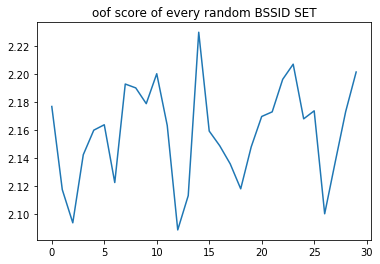

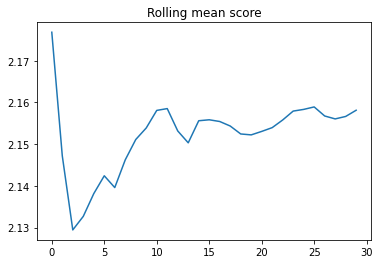

30
2.1581273
0.03496593


In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

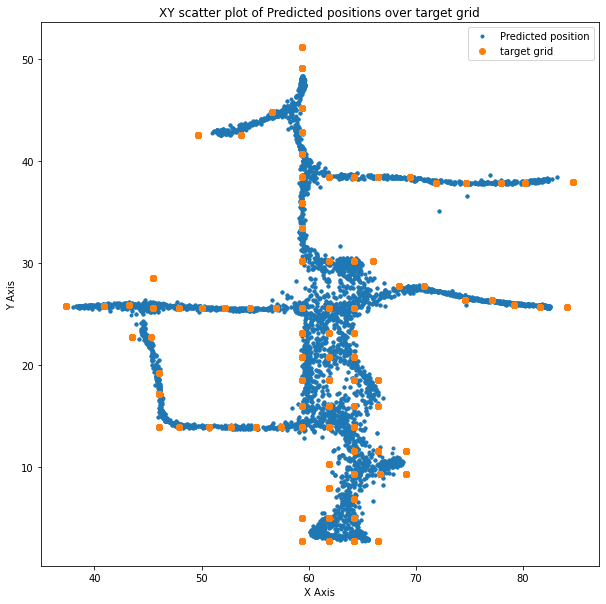

mean validation error, 5-fold 2.201355


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

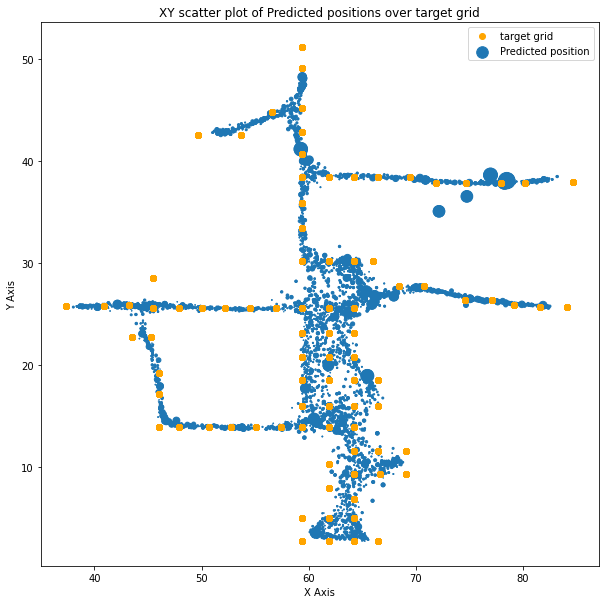

mean validation error, 5-fold 2.201355


In [ ]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

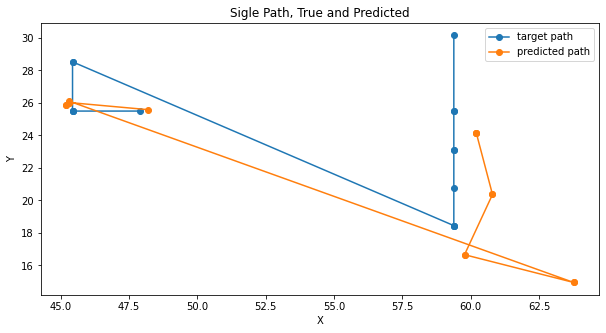

In [ ]:
# unp=data.path.unique()
import matplotlib.pyplot as plt
# ind=np.array(data.loc[data.path==unp[1],:].index)
X_val2 = data.loc[data.path.isin(val_paths),:].reset_index(drop=True)
ind=np.array(X_val2.loc[X_val2.path==val_paths[2],:].index)
plt.figure(figsize=(10,5))
plt.title('Sigle Path, True and Predicted')

# plt.plot(data.x.iloc[ind].values,data.y.iloc[ind].values,'-.')
plt.plot(all_targetsV[ind,0], all_targetsV[ind,1],'-o',label='target path')
plt.plot(all_predsV[ind,0], all_predsV[ind,1],'-o',label='predicted path')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# CROSS VALIDATION

name='keras'+version

scores=[]
for rs in range(40):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=211,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)

        X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)

        y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
        y_val = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
        epochs=140
        snapshots = 7
        lr_0 = 0.01
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=0,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])
            
        epochs=140
        snapshots = 7
        lr_0 = 0.001
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=0,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])

        # model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
        val_predsXY = model.predict(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1)) 

        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_val[:,0], y_val[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_val)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

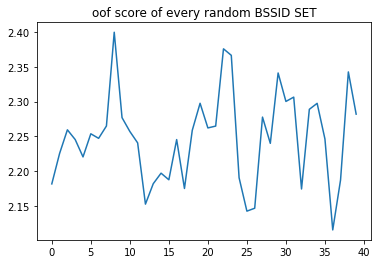

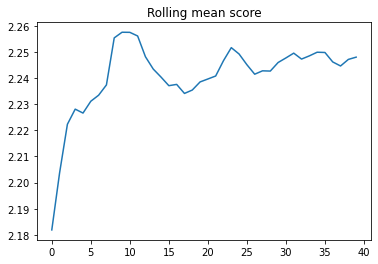

40
2.24802
0.06507332


In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

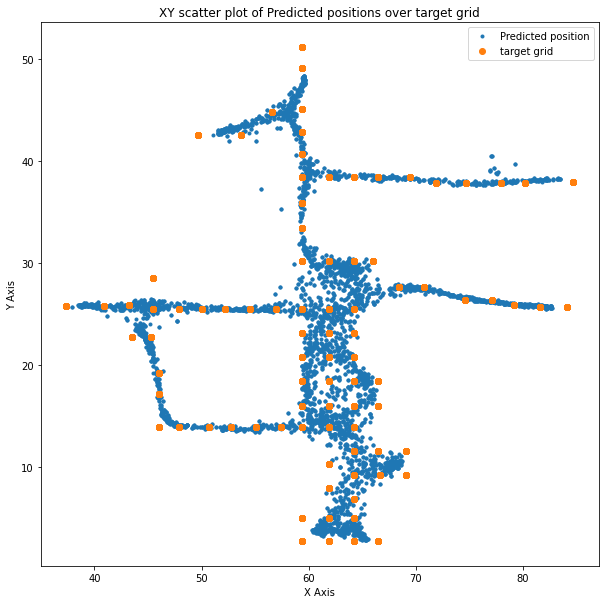

mean validation error, 5-fold 2.2819967


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

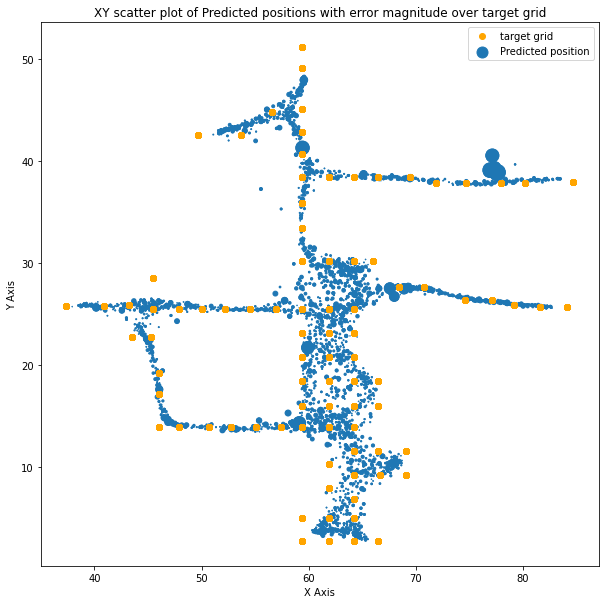

mean validation error, 5-fold 2.2819967


In [ ]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
# CROSS VALIDATION

name='keras'+version

scores=[]
for rs in range(50):
    unpaths=dataA.path.unique()
    np.random.seed(2022+rs)
    unpaths=np.random.choice(unpaths,size=106,replace=False)
    data=dataA.loc[dataA.path.isin(unpaths),:]


    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        # print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)

        X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)

        y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
        y_val = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
        epochs=140
        snapshots = 7
        lr_0 = 0.01
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=0,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])
            
        epochs=140
        snapshots = 7
        lr_0 = 0.001
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=0,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])

        # model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
        val_predsXY = model.predict(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1)) 

        
        # print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_val[:,0], y_val[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_val)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    
    print(rs,'mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    scores.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print(np.mean(scores))
    print('---------------------')

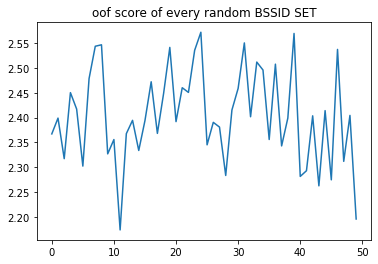

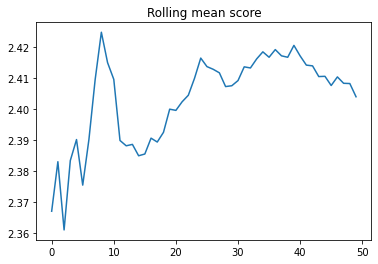

50
2.4039977
0.09544735


In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.title('oof score of every random BSSID SET')
plt.show()

plt.plot(np.cumsum(scores)/np.arange(1,len(scores)+1))
plt.title('Rolling mean score')
plt.show()

print(len(scores))
print(np.mean(scores))
print(np.std(scores))

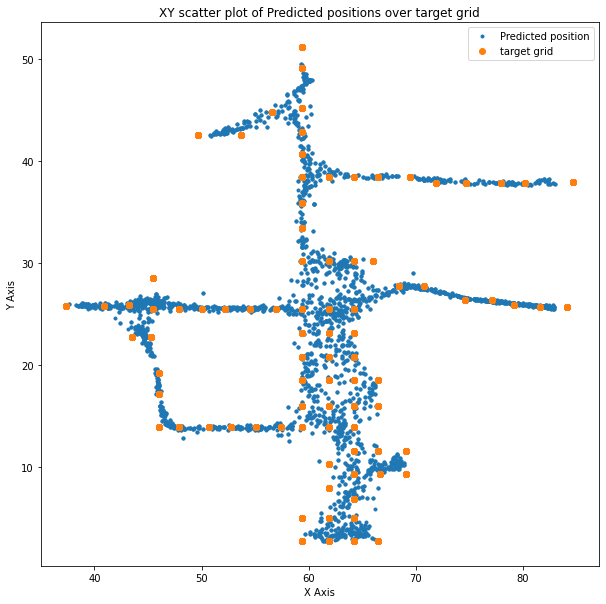

mean validation error, 5-fold 2.19541


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

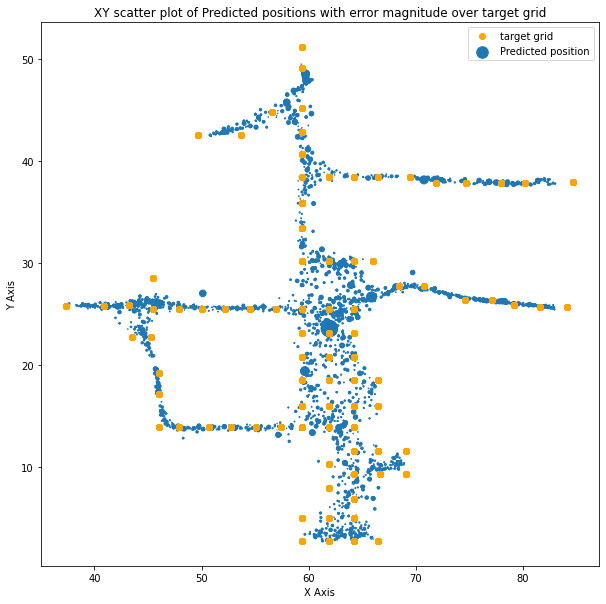

mean validation error, 5-fold 2.19541


In [ ]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions with error magnitude over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
# for NUM_FEATS in range(46,87,4):
    

In [ ]:
# # CROSS VALIDATION

# name='keras'+version


# np.random.seed(42)
# sh=np.random.permutation(unpaths)

# k=5
# val_size=int(len(sh)/k)
# alls=[]
# for NUM_FEATS in range(46,87,4):
#     print(NUM_FEATS)


#     score_df = pd.DataFrame()
#     oof = list()
#     predictions = list()

#     oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
#     preds_x, preds_y = 0, 0

#     scores_per_fold=[]

#     all_preds=[]
#     all_targets=[]

#     for f in range(k):
#         print('fold:', f)

#         if f<(k-1):
#             val_paths=sh[val_size*f:val_size*(f+1)]
#         else:
#             val_paths=sh[val_size*f:]

#         train_paths=[x for x in unpaths if x not in val_paths]
        
#         val_paths=np.array(val_paths)
#         train_paths=np.array(train_paths)

#         X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)

#         y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

#         X_val = data.loc[data.path.isin(val_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
#         y_val = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


#         model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
#         epochs=100
#         snapshots = 5
#         lr_0 = 0.01
#         lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

#         h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_train, 
#                     batch_size=128*8, epochs=epochs, verbose=0,
#                     validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_val),
#                     callbacks=[ lr_anneal1])
            
#         epochs=100
#         snapshots = 5
#         lr_0 = 0.001
#         lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

#         h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_train, 
#                     batch_size=128*8, epochs=epochs, verbose=0,
#                     validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_val),
#                     callbacks=[ lr_anneal1])

#         model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
#         val_predsXY = model.predict(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1)) 

        
#         print(f,euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_val[:,0], y_val[:,1]))

#         all_preds.append(val_predsXY)
#         all_targets.append(y_val)
            

#     all_predsV=np.vstack(all_preds)
#     all_targetsV=np.vstack(all_targets)    

#     alls.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
#     print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
name

'kerasforPdata423'

In [ ]:
# plt.plot(np.array(alls))
# plt.show()

In [ ]:
pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV.csv.gz', index=False, compression='gzip')

In [ ]:
l=pd.read_csv('/gdrive/My Drive/Colab Notebooks/lgbmforPdata423_oof.csv.gz')

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], l.x.values, l.y.values)

1.9529933161347668

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (l.x.values+all_predsV[:,0])/2, (l.y.values+all_predsV[:,1])/2)

1.933713321379115

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (2*l.x.values+all_predsV[:,0])/3, (2*l.y.values+all_predsV[:,1])/3)

1.9206065956477099

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (2.5*l.x.values+all_predsV[:,0])/3.5, (2.5*l.y.values+all_predsV[:,1])/3.5)

1.9205684892269967

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (l.x.values*all_predsV[:,0])**0.5, (l.y.values*all_predsV[:,1])**0.5)

1.9334018037272123

## EVALUATION - PLOTS

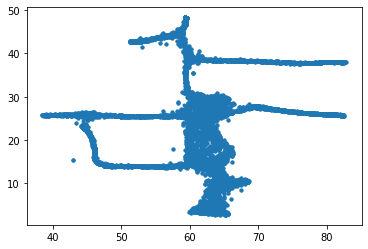

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

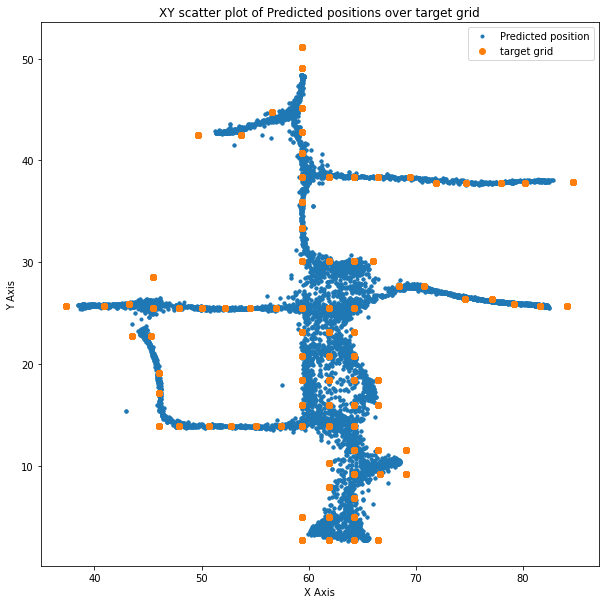

mean validation error, 5-fold 2.0872567


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

## Full train

In [ ]:


name='keras'+version

train_paths=unpaths[:]

train_paths=np.array(train_paths)
X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)#.values

y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
epochs=160
snapshots = 8
lr_0 = 0.01
lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                  y_train, 
                  batch_size=128*8, epochs=epochs, verbose=1,
                callbacks=[ lr_anneal1])

epochs=160
snapshots = 8
lr_0 = 0.001
lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                  y_train, 
                  batch_size=128*8, epochs=epochs, verbose=1,
                callbacks=[ lr_anneal1])
model.save_weights(weights_path+name+'_full'+'.hdf5')
train_predsXY = model.predict(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1))


print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_train[:,0], y_train[:,1]))
